# Model6

In [1]:
!ln -s ../data/ ./
!ln -s ../out/ ./

In [2]:
import os

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools
from pylab import rcParams
import matplotlib

# Package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from numpy import genfromtxt
import tensorflow as tf
import keras
from keras.layers import Activation, Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.contrib import learn
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn import metrics


%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load train data

In [3]:
train = pd.read_csv('data/Train_data/dataset_rev4_train.csv')
#buffer datetime
buffer_datetime_train = train.datetime
#remove object
train = train.select_dtypes(exclude=['object'])
#replace misssing value
train.fillna(0,inplace=True)

# Load data for test

In [4]:
test = pd.read_csv('data/test_data/dataset_rev4_test.csv')
#buffer datetime
buffer_datetime_test = test.datetime
#remove object
test = test.select_dtypes(exclude=['object'])
#replace misssing value
test.fillna(0,inplace=True)

In [5]:
print('dimension of train:', train.shape)
print('dimension of test:', test.shape)

dimension of train: (131586, 6)
dimension of test: (16147, 5)


In [6]:
print("features:",list(train.columns))

features: ['I', 'T', 'UV', 'WS', 'RH', 'P']


# Remove Outlier

In [7]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 13159
Number of rows without outliers: 118427


# Normalize

In [8]:
import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove('P')

mat_train = np.matrix(train)
mat_test  = np.matrix(test)

mat_new = np.matrix(train.drop('P',axis = 1))
mat_y = np.array(train.P).reshape((118427,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

# Input_fn

In [9]:
def input_fn(data_set, pred = False):
    if pred == False:      
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        labels = tf.constant(data_set[LABEL].values)      
        return feature_cols, labels
    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}      
        return feature_cols

# Create training_set and prediction_set

In [10]:
# List of features# List of 
COLUMNS = col_train #column train (x train)
FEATURES = col_train_bis  #column train-label (x test)
LABEL = "P"

# Columns
feature_cols = FEATURES #(x test)

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS] #column train (x train)
prediction_set = train.P # column P

In [11]:
print(type(training_set))
print(type(prediction_set))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


# Create x_train and Test

In [12]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)

In [13]:
print(type(x_train))
print(type(x_test))
print(type(y_train))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [14]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(79346, 5)
(39081, 5)
(79346,)
(39081,)


# Create training_set

In [15]:
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
training_sub = training_set[col_train]

# Create testing_set

In [16]:
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)

In [17]:
print( "Dimension of x_test = ", x_test.shape )
print( "Dimension of y_test = ", y_test.shape )
print( "Dimension of x_train = ", x_train.shape )
print( "Dimension of y_train = ", y_train.shape )

Dimension of x_test =  (39081, 5)
Dimension of y_test =  (39081, 1)
Dimension of x_train =  (79346, 5)
Dimension of y_train =  (79346, 1)


# We scale the inputs to have mean 0 and standard variation 1.

In [18]:
#scaler = preprocessing.StandardScaler( )
#train_x = scaler.fit_transform( train_x )
#test_x  = scaler.fit_transform( test_x )

# We verify that we have 5 features...

In [19]:
numFeatures =  x_train.shape[1] 
print( "number of features = ", numFeatures )

number of features =  5


<h2>Input & Output Place-Holders</h2>
Define 2 place holders to the graph, one for the inputs one for the outputs...

In [20]:
with tf.name_scope("IO"):
    inputs = tf.placeholder(tf.float32, [None, numFeatures], name="X")
    outputs = tf.placeholder(tf.float32, [None, 1], name="Yhat")

<h2>Define the Coeffs for the Layers</h2>
For each layer the input vector will be multiplied by a matrix $h$ of dim $n$ x $m$, where $n$ is the dimension of the input vector and $m$ the dimention of the output vector.   Then a bias vector of dimension $m$ is added to the product.

In [21]:
with tf.name_scope("LAYER"):
    # network architecture
    Layers = [numFeatures, 52, 39, 26, 13, 1]
    
    h1   = tf.Variable(tf.random_normal([Layers[0], Layers[1]], 0, 0.1, dtype=tf.float32), name="h1")
    h2   = tf.Variable(tf.random_normal([Layers[1], Layers[2]], 0, 0.1, dtype=tf.float32), name="h2")
    h3   = tf.Variable(tf.random_normal([Layers[2], Layers[3]], 0, 0.1, dtype=tf.float32), name="h3")
    h4   = tf.Variable(tf.random_normal([Layers[3], Layers[4]], 0, 0.1, dtype=tf.float32), name="h4")
    hout = tf.Variable(tf.random_normal([Layers[4], Layers[5]], 0, 0.1, dtype=tf.float32), name="hout")

    b1   = tf.Variable(tf.random_normal([Layers[1]], 0, 0.1, dtype=tf.float32 ), name="b1" )
    b2   = tf.Variable(tf.random_normal([Layers[2]], 0, 0.1, dtype=tf.float32 ), name="b2" )
    b3   = tf.Variable(tf.random_normal([Layers[3]], 0, 0.1, dtype=tf.float32 ), name="b3" )
    b4   = tf.Variable(tf.random_normal([Layers[4]], 0, 0.1, dtype=tf.float32 ), name="b4" )
    bout = tf.Variable(tf.random_normal([Layers[5]], 0, 0.1, dtype=tf.float32 ), name="bout" )

<h2>Define the Layer operations as a Python funtion</h2>

In [22]:
def model( inputs, layers ):
    [h1, b1, h2, b2, h3, b3, hout, bout] = layers
    y1 = tf.add( tf.matmul(inputs, h1), b1 )
    y1 = tf.nn.relu( y1 )
       
    y2 = tf.add( tf.matmul(y1, h2), b2 )
    y2 = tf.nn.relu( y2 )

    y3 = tf.add( tf.matmul(y2, h3), b3 )
    y3 = tf.nn.relu( y3 )

    y4 = tf.add( tf.matmul(y3, h4), b4 )
    y4 = tf.nn.relu( y4 )

    yret  = tf.matmul(y4, hout) + bout 
    return yret

<h2>Define the operations that are performed</h2>
We define what happens to the inputs (x), when they are provided, and what we do with 
the outputs of the layers (compare them to the y values), and the type of minimization 
that must be done.

In [23]:
with tf.name_scope("train"):
    learning_rate = 0.50
    yout = model( inputs, [h1, b1, h2, b2, h3, b3, hout, bout] )
    
    cost_op = tf.reduce_mean( tf.pow( yout - outputs, 2 ))
    #cost_op = tf.reduce_sum( tf.pow( yout - outputs, 2 ))
    #cost_op =  tf.reduce_mean(-tf.reduce_sum( yout * tf.log( outputs ) ) )

    #train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_op)
    #train_op = tf.train.AdamOptimizer( learning_rate=learning_rate ).minimize( cost_op )
    train_op = tf.train.AdagradOptimizer( learning_rate=learning_rate ).minimize( cost_op )

<h2>Train the Model</h2>
We are now ready to go through many sessions, and in each one train the model.  Here we train on the whole x-train and y-train data, rather than batching into smaller groups.

In [24]:
# define variables/constants that control the training
epoch = 0
last_cost = 0
#max_epochs = 100
max_epochs = 50000
tolerance = 1e-6

print( "Beginning Training" )

sess = tf.Session() # Create TensorFlow session
with sess.as_default():
    
    # initialize the variables
    init = tf.initialize_all_variables()
    sess.run(init)
    
    # start training until we stop, either because we've reached the max
    # number of epochs, or successive errors are close enough to each other
    # (less than tolerance)
    
    costs = []
    epochs= []
    while True:
        # Do the training
        sess.run( train_op, feed_dict={inputs: x_train, outputs: y_train} )
            
        # Update the user every 1000 epochs
        if epoch % 1000==0:
            cost = sess.run(cost_op, feed_dict={inputs: x_train, outputs: y_train})
            costs.append( cost )
            epochs.append( epoch )
            
            print( "Epoch: %d - Error: %.4f" %(epoch, cost) )
            
            # time to stop?
            if epoch > max_epochs :
                # or abs(last_cost - cost) < tolerance:
                print( "STOP!" )
                break
            last_cost = cost
            
        epoch += 1
    
    # we're done...
    # print some statistics...
    
    print( "Test Cost =", sess.run(cost_op, feed_dict={inputs: x_test, outputs: y_test}) )

    # compute the predicted output for test_x
    pred_y = sess.run( yout, feed_dict={inputs: x_test, outputs: y_test} )
    
    print( "\nPrediction\nreal\tpredicted" )
    for (y, yHat ) in list(zip( y_test.values, pred_y ))[0:10]:
        print( "%1.1f\t%1.1f" % (y, yHat ) )

Beginning Training
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0 - Error: 0.1134
Epoch: 1000 - Error: 0.0516
Epoch: 2000 - Error: 0.0516
Epoch: 3000 - Error: 0.0516
Epoch: 4000 - Error: 0.0516
Epoch: 5000 - Error: 0.0516
Epoch: 6000 - Error: 0.0516
Epoch: 7000 - Error: 0.0516
Epoch: 8000 - Error: 0.0516
Epoch: 9000 - Error: 0.0516
Epoch: 10000 - Error: 0.0516
Epoch: 11000 - Error: 0.0516
Epoch: 12000 - Error: 0.0516
Epoch: 13000 - Error: 0.0516
Epoch: 14000 - Error: 0.0516
Epoch: 15000 - Error: 0.0516
Epoch: 16000 - Error: 0.0516
Epoch: 17000 - Error: 0.0516
Epoch: 18000 - Error: 0.0516
Epoch: 19000 - Error: 0.0516
Epoch: 20000 - Error: 0.0516
Epoch: 21000 - Error: 0.0516
Epoch: 22000 - Error: 0.0516
Epoch: 23000 - Error: 0.0516
Epoch: 24000 - Error: 0.0516
Epoch: 25000 - Error: 0.0516
Epoch: 26000 - Error: 0.0516
Epoch: 27000 - Error: 0.0516
Epoch: 28000 - Error: 0.0516
Epoch: 29000 - Error: 0.0516
Epoch: 30000 - Error: 0.0516
Epoch: 31000 - Error:

In [25]:
print(type(y_test))
print(type(pred_y))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


<h2>R2 score</h2>

In [26]:
r2 =  metrics.r2_score(y_test, pred_y) 
print( "mean squared error = ", metrics.mean_squared_error(y_test, pred_y))
print( "r2 score (coef determination) = ", metrics.r2_score(y_test, pred_y))

mean squared error =  0.050997341312131364
r2 score (coef determination) =  -3.017885274791965e-05


<h2>Plot Prediction vs. Real Housing Price</h2>

<h2>Plot Cost vs Epochs</h2>

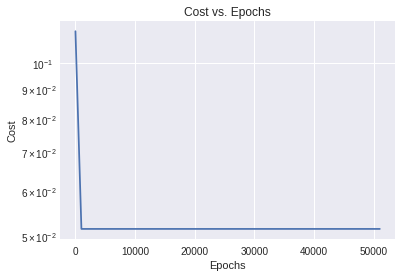

In [27]:
    fig = plt.figure()
    plt.semilogy( epochs, costs )
    plt.xlabel( "Epochs" )
    plt.ylabel( "Cost" )
    plt.title( "Cost vs. Epochs")
    plt.show()
    fig.savefig('CostVsEpochs.png', bbox_inches='tight')